In [4]:
pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm

import warnings

warnings.simplefilter('ignore')

## Exploração dos Dados

In [2]:
df = pd.read_csv("data_updated.csv")

df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()

print("Estrutura dos Dados:")
print(df.info())
display(df.tail())
display(df.describe())

Estrutura dos Dados:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2022-10-31 to 2025-10-27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  157 non-null    float64
 1   inv     157 non-null    float64
 2   users   157 non-null    float64
dtypes: float64(3)
memory usage: 4.9 KB
None


,volume,inv,users
week,,,
2025-09-29,20.33,1.144344,9.575
2025-10-06,14.50,0.520285,4.504
2025-10-13,17.89,0.837998,7.296
2025-10-20,24.52,1.422242,12.458
2025-10-27,20.44,1.120301,8.521


,volume,inv,users
count,157.000000,157.000000,157.000000
mean,4.820382,0.712956,6.576834
std,5.162304,0.889207,6.596819
min,0.140000,0.000240,0.401000
25%,0.660000,0.076311,1.351000
50%,3.250000,0.464850,3.847000
75%,7.550000,0.859225,9.768000
max,24.520000,5.623875,29.332000


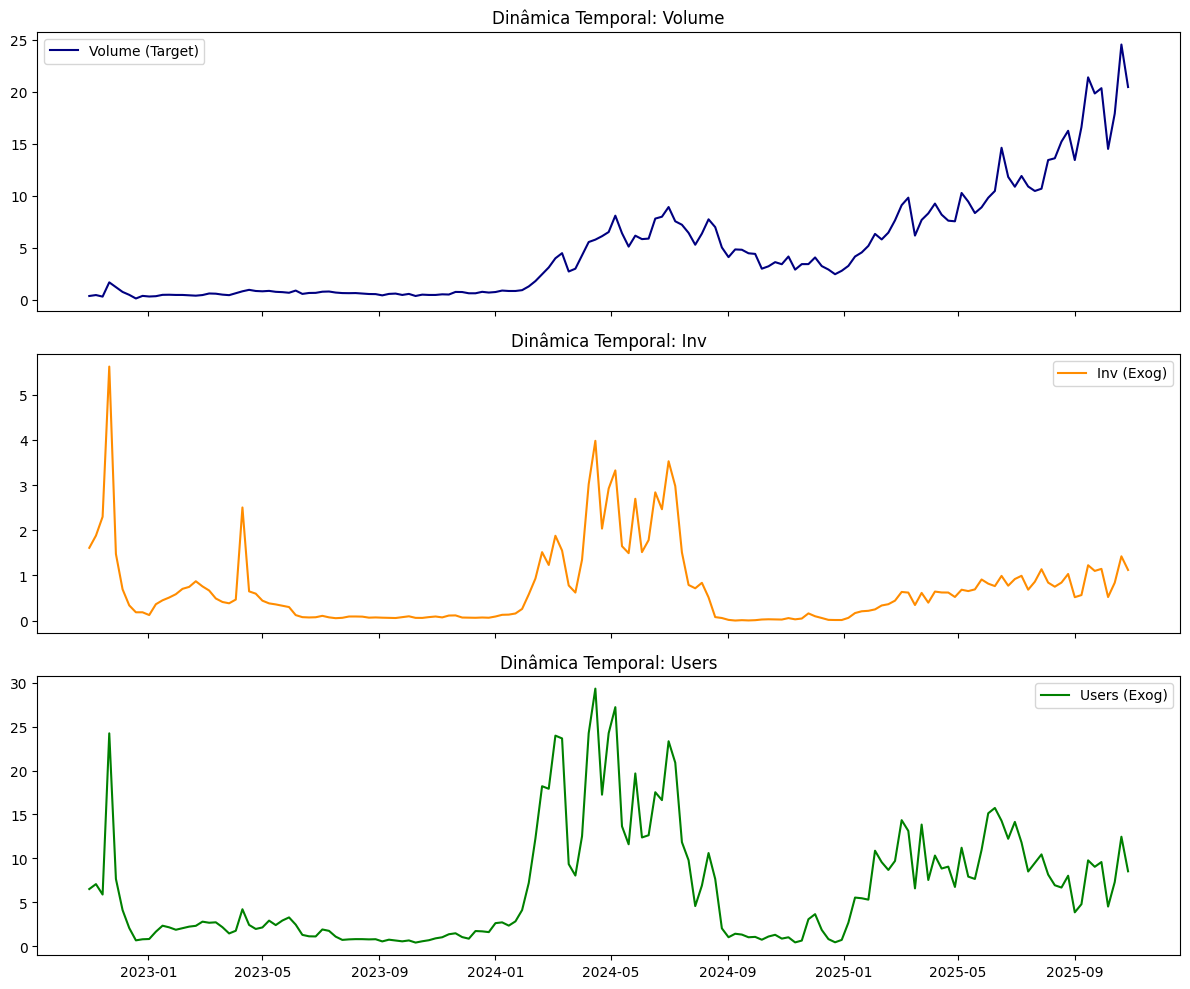

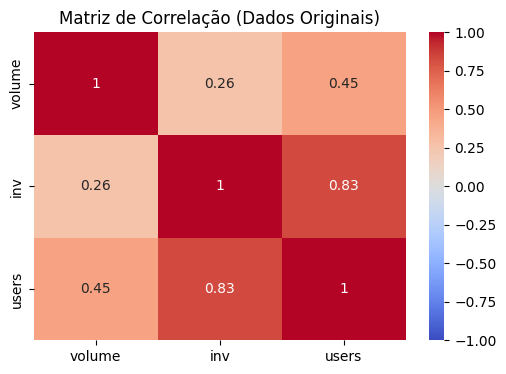

In [3]:
# 1. Visualização das Séries no Tempo
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

axes[0].plot(df.index, df['volume'], color='navy', label='Volume (Target)')
axes[0].set_title('Dinâmica Temporal: Volume')
axes[0].legend()
axes[0].grid(False)

axes[1].plot(df.index, df['inv'], color='darkorange', label='Inv (Exog)')
axes[1].set_title('Dinâmica Temporal: Inv')
axes[1].legend()
axes[1].grid(False)

axes[2].plot(df.index, df['users'], color='green', label='Users (Exog)')
axes[2].set_title('Dinâmica Temporal: Users')
axes[2].legend()
axes[2].grid(False)

plt.tight_layout()
plt.show()

# 2. Matriz de Correlação
corr_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Dados Originais)')
plt.show()

Como esperávamos, levando em conta o conhecimento do problema (users provavelmente é a quantidade de pessoas que compraram ou usaram um produto), as variáveis users e volume apresentam uma correlação razoável.

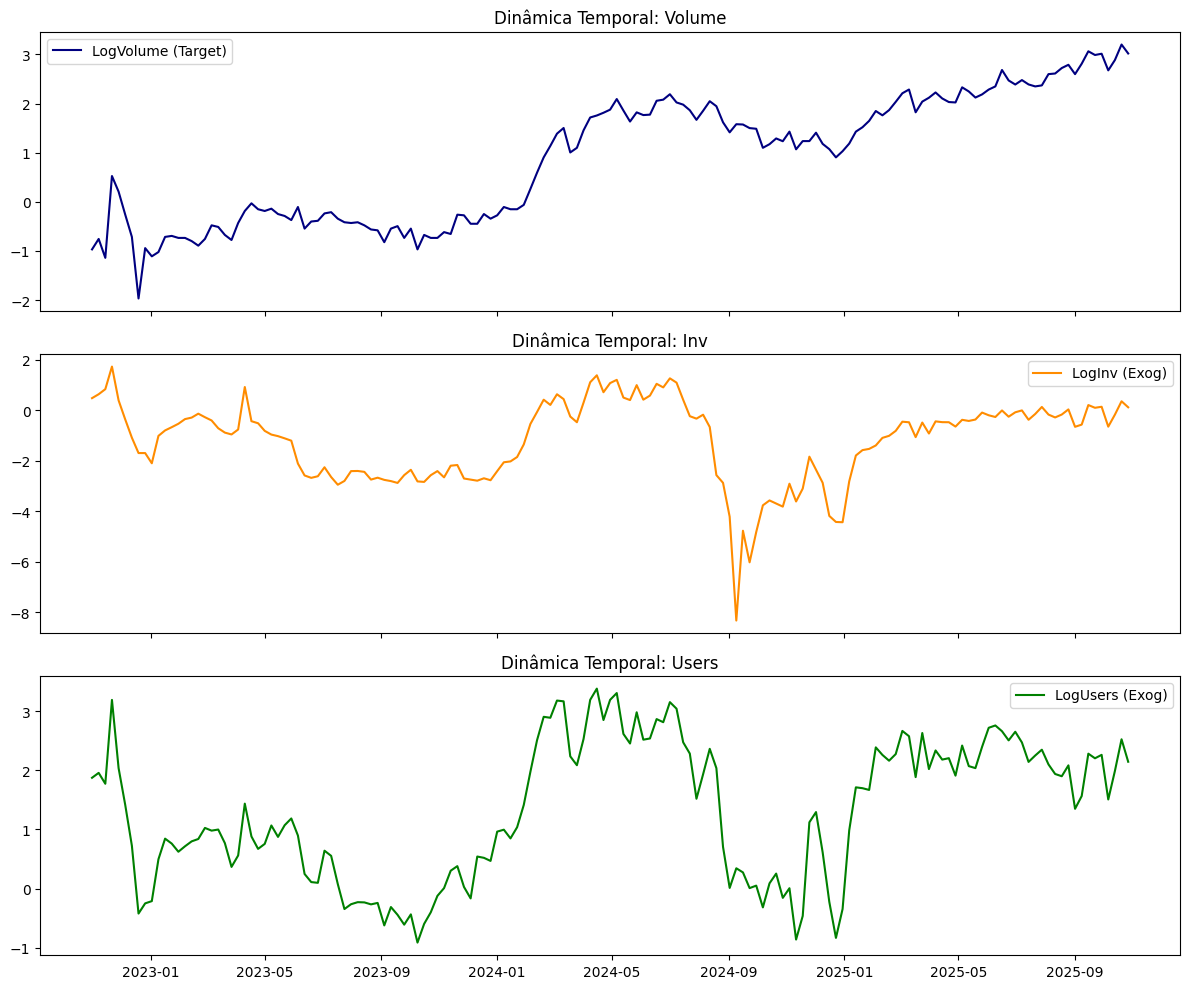

Correlação após Transformação Logarítmica:


,log_volume,log_inv,log_users
log_volume,1.000000,0.313855,0.674262
log_inv,0.313855,1.000000,0.806567
log_users,0.674262,0.806567,1.000000


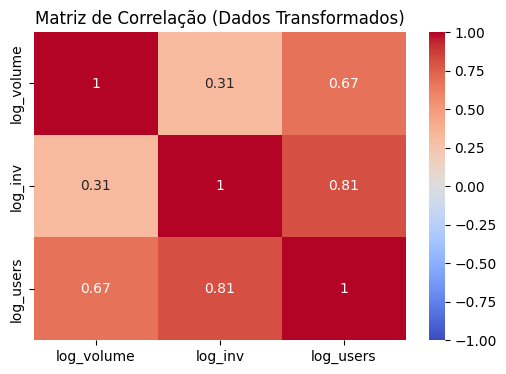

In [5]:
df['log_volume'] = np.log(df['volume'])
df['log_inv'] = np.log(df['inv'].replace(0, 0.001)) # Evitando log(0)
df['log_users'] = np.log(df['users'].replace(0, 0.001))

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

axes[0].plot(df.index, df['log_volume'], color='navy', label='LogVolume (Target)')
axes[0].set_title('Dinâmica Temporal: Volume')
axes[0].legend()
axes[0].grid(False)

axes[1].plot(df.index, df['log_inv'], color='darkorange', label='LogInv (Exog)')
axes[1].set_title('Dinâmica Temporal: Inv')
axes[1].legend()
axes[1].grid(False)

axes[2].plot(df.index, df['log_users'], color='green', label='LogUsers (Exog)')
axes[2].set_title('Dinâmica Temporal: Users')
axes[2].legend()
axes[2].grid(False)

plt.tight_layout()
plt.show()

# Correlação após Log
# Às vezes a relação fica mais linear (melhor para SARIMAX/Regressão) no espaço Log
print("Correlação após Transformação Logarítmica:")
corr_matrix = df[['log_volume', 'log_inv', 'log_users']].corr()
display(corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Dados Transformados)')
plt.show()

A correlação linear entre as covariáveis e "volume" aumenta se aplicarmos log nelas, isso pode ser interessante para construir os modelos para ter melhores resultados. Vale observar, porém, que a correlação entre as variáveis `inv` e `users` é alta, o que pode ser prejudicial para alguns modelos, já que as informações de cada coluna serão quase colineares.

## Funções Auxliares de Avaliação de Modelos

In [6]:
def calculate_mase(y_true, y_pred, y_train, m=52):
    forecast_error = np.mean(np.abs(y_true - y_pred))
    naive_seasonal_errors = np.abs(y_train[m:] - y_train[:-m])
    mae_naive = np.mean(naive_seasonal_errors)

    if mae_naive == 0:
        return np.nan

    return forecast_error / mae_naive

def inverse_transform(y_log):
    return np.exp(y_log)

def walk_forward_validation(df, target_col, exog_cols, model_func,
                            initial_train_size=104, horizon=4, m=52, log_transformed = True, **model_params):
    results = []
    n_samples = len(df)
    for t in range(initial_train_size, n_samples - horizon + 1):
        train = df.iloc[:t]
        test = df.iloc[t : t + horizon]

        # Dados de treino na escala ORIGINAL para cálculo do MASE
        # Assumindo que o dataframe tem colunas originais 'volume' além das log
        if log_transformed:
            train_original = np.exp(train[target_col])
        else:
            train_original = train[target_col]

        # 2. Treinamento e Previsão (Usando a função do modelo que passaremos depois)
        # A função deve retornar as previsões (yhat) na escala LOG
        yhat_log = model_func(train, test, target_col, exog_cols, horizon, **model_params)

        # 3. Re-escala para Original
        if log_transformed:
            y_pred_original = inverse_transform(yhat_log)
            y_true_original = np.exp(test[target_col].values) # Target real das próximas h semanas

        else:
            y_pred_original = yhat_log
            y_true_original = test[target_col].values

        # 4. Avaliação por horizonte (h=1, h=2, h=3, h=4)
        for h in range(horizon):
            # Pega o valor único para o horizonte h+1
            pred_h = y_pred_original[h]
            true_h = y_true_original[h]

            # Calcula erro pontual
            abs_error = np.abs(true_h - pred_h)
            sq_error = (true_h - pred_h) ** 2

            # Para o MASE, precisamos passar a série de treino inteira para calcular o denominador
            # Aqui calculamos o MASE pontual para esse horizonte específico
            mase_score = calculate_mase(np.array([true_h]), np.array([pred_h]), train_original.values, m)

            results.append({
                'cutoff_date': train.index[-1],
                'horizon': h + 1,
                'y_true': true_h,
                'y_pred': pred_h,
                'abs_error': abs_error,
                'sq_error': sq_error,
                'mase': mase_score
            })

    results_df = pd.DataFrame(results)
    metrics_per_h = results_df.groupby('horizon').agg({
        'abs_error': 'mean',   # MAE
        'sq_error': lambda x: np.sqrt(np.mean(x)), # RMSE
        'mase': 'mean'         # MASE Médio
    }).rename(columns={'abs_error': 'MAE', 'sq_error': 'RMSE', 'mase': 'MASE'})

    return metrics_per_h, results_df

## Modelos

Escolhemos alguns modelos vistos em sala para explorá-los.

### Regressão linear sem informação temporal

In [7]:
def linear_model(train_df, test_df, target_col, exog_cols, horizon, **params):
    
    X_train = train_df[exog_cols].copy()
    y_train = train_df[target_col]
    X_train = sm.add_constant(X_train, has_constant='add')

    model = sm.OLS(y_train, X_train)
    results = model.fit()
    
    X_test = test_df.iloc[:horizon][exog_cols].copy()
    X_test = sm.add_constant(X_test, has_constant='add')
    
    predictions = results.predict(X_test)
    
    return predictions.values

In [9]:
TARGET = 'log_volume'
EXOG_LINEAR = ["log_users", "log_inv"]
HORIZON = 4
INITIAL_TRAIN = 104 # ~2 anos
M = 52

metrics_linear_full, _ = walk_forward_validation(df, "volume", ["users", "inv"], linear_model, INITIAL_TRAIN, HORIZON, M, log_transformed = False)
metrics_linear_users, _ = walk_forward_validation(df, "volume", ["users"], linear_model, INITIAL_TRAIN, HORIZON, M, log_transformed = False)
metrics_linear_log_full, _ = walk_forward_validation(df, "volume", ["log_users", "log_inv"], linear_model, INITIAL_TRAIN, HORIZON, M, log_transformed = False)
metrics_linear_log_users, _ = walk_forward_validation(df, "volume", ["log_users"], linear_model, INITIAL_TRAIN, HORIZON, M, log_transformed = False)

final_comparison = pd.DataFrame({
    'MAE (h=1)': [metrics_linear_full.loc[1, 'MAE'], metrics_linear_users.loc[1, 'MAE'], metrics_linear_log_full.loc[1, 'MAE'], metrics_linear_log_users.loc[1, 'MAE']],
    'RMSE (h=1)': [metrics_linear_full.loc[1, 'RMSE'], metrics_linear_users.loc[1, 'RMSE'], metrics_linear_log_full.loc[1, 'RMSE'], metrics_linear_log_users.loc[1, 'RMSE']],
    'MASE (h=1)': [metrics_linear_full.loc[1, 'MASE'], metrics_linear_users.loc[1, 'MASE'], metrics_linear_log_full.loc[1, 'MASE'], metrics_linear_log_users.loc[1, 'MASE']],
    'MASE (h=4)': [metrics_linear_full.loc[4, 'MASE'], metrics_linear_users.loc[4, 'MASE'], metrics_linear_log_full.loc[4, 'MASE'], metrics_linear_log_users.loc[4, 'MASE']],
    'RMSE (h=4)': [metrics_linear_full.loc[4, 'RMSE'], metrics_linear_users.loc[4, 'RMSE'], metrics_linear_log_full.loc[4, 'RMSE'], metrics_linear_log_users.loc[4, 'RMSE']]
}, index=['Linear regression', 'linear regression (only users)', 'linear regression (log exog)', 'linear regression (log exog, only users)'])

def highlight_winner(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; font-weight: bold' if v else '' for v in is_min]

display(final_comparison.style.apply(highlight_winner).format("{:.4f}"))

,MAE (h=1),RMSE (h=1),MASE (h=1),MASE (h=4),RMSE (h=4)
Linear regression,5.0444,6.5153,1.4160,1.6985,7.7232
linear regression (only users),5.5627,6.7705,1.5697,1.8364,7.9032
linear regression (log exog),4.6223,6.0683,1.2964,1.5466,7.2055
"linear regression (log exog, only users)",4.9678,6.0963,1.4004,1.6403,7.1818


### ETS

In [8]:
def holt_trend_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    model = ExponentialSmoothing(
        train_df[target_col],
        trend='add',
        damped_trend=True,
        seasonal=None,
        initialization_method='estimated'
    )
    return model.fit(optimized=True).forecast(steps=horizon)

def holt_winters_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    model = ExponentialSmoothing(
        train_df[target_col],
        trend='add',
        damped_trend=True,
        seasonal='add',
        seasonal_periods=52,
        initialization_method='estimated'
    )
    return model.fit(optimized=True).forecast(steps=horizon)

def calculate_internal_metrics(df, target_col, initial_train_size):
    train_data = df[target_col].iloc[:initial_train_size]
    metrics = []
    models = [
        ('Holt (Trend Only)', {'trend': 'add', 'seasonal': None, 'damped': True}),
        ('Holt-Winters (Seasonal)', {'trend': 'add', 'seasonal': 'add', 'damped': True})
    ]

    print(f">>> Calculando AIC/BIC (Treino: {len(train_data)} semanas)...")
    for name, params in models:
        m = ExponentialSmoothing(
            train_data,
            trend=params['trend'],
            damped_trend=params['damped'],
            seasonal=params['seasonal'],
            seasonal_periods=52 if params['seasonal'] else None,
            initialization_method='estimated'
        )
        fit = m.fit(optimized=True)
        metrics.append({'Modelo': name, 'AICc': fit.aicc, 'BIC': fit.bic})
    return pd.DataFrame(metrics).set_index('Modelo')


In [9]:
df_internal = calculate_internal_metrics(df, TARGET, INITIAL_TRAIN)

# B. Walk-Forward (Métricas Externas)
print(">>> Rodando Walk-Forward: Holt (Trend Only)...")
metrics_holt, _ = walk_forward_validation(df, TARGET, [], holt_trend_func, INITIAL_TRAIN, HORIZON, M)

print(">>> Rodando Walk-Forward: Holt-Winters (Seasonal)...")
metrics_hw, _ = walk_forward_validation(df, TARGET, [], holt_winters_func, INITIAL_TRAIN, HORIZON, M)

# C. Construção da Tabela Detalhada por 'h'
summary_data = {
    'AICc': df_internal['AICc'],
    'BIC': df_internal['BIC']
}

# Adiciona colunas para cada horizonte (MASE e RMSE)
for h in range(1, HORIZON + 1):
    summary_data[f'MASE (h={h})'] = [
        metrics_holt.loc[h, 'MASE'],
        metrics_hw.loc[h, 'MASE']
    ]

# Adiciona RMSE apenas do h=4 para não poluir demais (ou descomente o loop abaixo para todos)
summary_data[f'RMSE (h={HORIZON})'] = [
    metrics_holt.loc[HORIZON, 'RMSE'],
    metrics_hw.loc[HORIZON, 'RMSE']
]

summary_df = pd.DataFrame(summary_data, index=['Holt (Trend Only)', 'Holt-Winters (Seasonal)'])

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; color: black; font-weight: bold' if v else '' for v in is_min]

# Formatação para facilitar leitura
format_dict = {'AICc': '{:.1f}', 'BIC': '{:.1f}'}
for col in summary_df.columns:
    if 'MASE' in col or 'RMSE' in col:
        format_dict[col] = '{:.4f}'

display(summary_df.style.apply(highlight_min).format(format_dict))


>>> Calculando AIC/BIC (Treino: 104 semanas)...
>>> Rodando Walk-Forward: Holt (Trend Only)...
>>> Rodando Walk-Forward: Holt-Winters (Seasonal)...


,AICc,BIC,MASE (h=1),MASE (h=2),MASE (h=3),MASE (h=4),RMSE (h=4)
Holt (Trend Only),-243.0,-230.9,0.3528,0.4864,0.5579,0.5413,2.4907
Holt-Winters (Seasonal),-79.5,-89.6,0.3749,0.5654,0.7380,0.8609,3.9798


### Arima

In [29]:
def sarimax_model_func(train_df, test_df, target_col, exog_cols, horizon, **params):
    y_train = train_df[target_col]
    X_train = train_df[exog_cols]
    X_test = test_df[exog_cols] # Exógenas futuras (reais no teste)
    model = pm.auto_arima(
        y_train,
        X=X_train,
        start_p=1, start_q=1,
        max_p=2, max_q=2, # Limitando para evitar explosão combinatória
        m=52,             # Sazonalidade anual
        seasonal=True,    # Ativa componente sazonal (P,D,Q)
        d=None,           # Deixa o teste (KPSS) decidir a diferenciação
        test='kpss',
        information_criterion='aicc', # SELEÇÃO VIA AICc
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True     # Otimização rápida (não testa todas as combinações possíveis)
    )

    forecast = model.predict(n_periods=horizon, X=X_test)
    return forecast

In [30]:
EXOG_SARIMAX = ['log_inv', 'log_users']
metrics_sarimax, _ = walk_forward_validation(
    df,
    TARGET,
    EXOG_SARIMAX, # Aqui passamos as exógenas!
    sarimax_model_func,
    INITIAL_TRAIN,
    HORIZON,
    M
)

final_comparison = pd.DataFrame({
    'MASE (h=1)': [metrics_holt.loc[1, 'MASE'], metrics_sarimax.loc[1, 'MASE']],
    'MASE (h=4)': [metrics_holt.loc[4, 'MASE'], metrics_sarimax.loc[4, 'MASE']],
    'RMSE (h=4)': [metrics_holt.loc[4, 'RMSE'], metrics_sarimax.loc[4, 'RMSE']]
}, index=['ETS (Holt Trend)', 'SARIMAX (Exog)'])

def highlight_winner(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; font-weight: bold' if v else '' for v in is_min]

display(final_comparison.style.apply(highlight_winner).format("{:.4f}"))

KeyboardInterrupt: 

In [ ]:
EXOG_SARIMAX = ['log_users']
metrics_sarimax, _ = walk_forward_validation(
    df,
    TARGET,
    EXOG_SARIMAX, # Aqui passamos as exógenas!
    sarimax_model_func,
    INITIAL_TRAIN,
    HORIZON,
    M
)

final_comparison = pd.DataFrame({
    'MASE (h=1)': [metrics_holt.loc[1, 'MASE'], metrics_sarimax.loc[1, 'MASE']],
    'MASE (h=4)': [metrics_holt.loc[4, 'MASE'], metrics_sarimax.loc[4, 'MASE']],
    'RMSE (h=4)': [metrics_holt.loc[4, 'RMSE'], metrics_sarimax.loc[4, 'RMSE']]
}, index=['ETS (Holt Trend)', 'SARIMAX (Exog)'])

def highlight_winner(s):
    is_min = s == s.min()
    return ['background-color: #d6f5d6; font-weight: bold' if v else '' for v in is_min]

display(final_comparison.style.apply(highlight_winner).format("{:.4f}"))

,MASE (h=1),MASE (h=4),RMSE (h=4)
ETS (Holt Trend),0.3528,0.5413,2.4907
SARIMAX (Exog),0.2720,0.4375,2.0069


Assim como levantado acima, a alta correlação entre as duas covariáveis poderia indicar que usar as duas em um modelo poderia piorar o desempenho dele. Esse resultado se mostrou real para o modelo SARIMAX, apesar do ganho de desempenho não ser tão grande.

# Análise dos Modelos Baseline (dataset atualizado)
Replica o protocolo do relatório com walk-forward, busca de sazonalidade do Seasonal Naive e inspeção gráfica de resíduos para o `volume` no dataset novo.

## 1. Procedimento de Validação: Walk-Forward
O método de avaliação *walk-forward* mantém a ordem temporal e atualiza o modelo a cada passo, evitando vazamento de informação. Em cada iteração:
- Ajusta o modelo com todos os dados até a semana `t`.
- Faz previsão genuinamente fora da amostra para as próximas `H` semanas.
- Incorpora o valor real e avança a janela, permitindo acompanhar estabilidade temporal e simular uso em produção.

In [28]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("colorblind")

HORIZON = 4          # semanas à frente
INITIAL_TRAIN = 52   # uma janela inicial (~1 ano)
SEASONALITY = 52     # sazonalidade semanal padrão

## 2. Carregar dados (volume)
Consideramos apenas `volume` para replicar a análise baseline do relatório anterior.

In [29]:
DATA_PATH = Path("data_updated.csv")
df = pd.read_csv(DATA_PATH)
df["week"] = pd.to_datetime(df["week"])
df = df.sort_values("week").set_index("week")
df["volume"] = df["volume"].astype(float)

print(df.info())
display(df.head())
display(df[["volume"]].describe().T)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2022-10-31 to 2025-10-27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  157 non-null    float64
 1   inv     157 non-null    float64
 2   users   157 non-null    float64
dtypes: float64(3)
memory usage: 4.9 KB
None


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


,count,mean,std,min,25%,50%,75%,max
volume,157.0,4.820382,5.162304,0.14,0.66,3.25,7.55,24.52


## 3. Funções auxiliares e métricas
Inclui o *walk-forward*, as funções dos baselines e agregadores de métricas (R², MAE, MSE, RMSE e média dos resíduos).

In [30]:
def walk_forward(df, target_col, model_func, model_kwargs=None, initial_train_size=INITIAL_TRAIN, horizon=HORIZON):
    '''Executa walk-forward com janela crescente.'''
    model_kwargs = model_kwargs or {}
    records = []
    n = len(df)
    for cutoff in range(initial_train_size, n - horizon + 1):
        train = df.iloc[:cutoff]
        test = df.iloc[cutoff : cutoff + horizon]

        preds = np.asarray(model_func(train, test, target_col, horizon, **model_kwargs))
        truth = test[target_col].values

        for h, (y_true, y_pred) in enumerate(zip(truth, preds), start=1):
            records.append(
                {
                    "cutoff": train.index[-1],
                    "horizon": h,
                    "y_true": y_true,
                    "y_pred": y_pred,
                    "residual": y_true - y_pred,
                }
            )

    return pd.DataFrame(records)


def aggregate_metrics(res_df):
    y_true = res_df["y_true"].values
    y_pred = res_df["y_pred"].values
    residual = y_true - y_pred
    mae = np.mean(np.abs(residual))
    mse = np.mean(residual**2)
    rmse = np.sqrt(mse)
    ss_res = np.sum(residual**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return {
        "R2": r2,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Media dos Residuos": residual.mean(),
    }


def naive_last(train_df, test_df, target_col, horizon, **kwargs):
    last_val = train_df[target_col].iloc[-1]
    return np.repeat(last_val, horizon)


def seasonal_naive(train_df, test_df, target_col, horizon, s=SEASONALITY, **kwargs):
    series = train_df[target_col].values
    if len(series) < s:
        return naive_last(train_df, test_df, target_col, horizon)
    tail = series[-s:]
    reps = int(np.ceil(horizon / s))
    return np.tile(tail, reps)[:horizon]


def mean_history(train_df, test_df, target_col, horizon, **kwargs):
    mean_val = train_df[target_col].mean()
    return np.repeat(mean_val, horizon)


def drift(train_df, test_df, target_col, horizon, **kwargs):
    series = train_df[target_col].values
    if len(series) < 2:
        return naive_last(train_df, test_df, target_col, horizon)
    slope = (series[-1] - series[0]) / (len(series) - 1)
    base = series[-1]
    return np.array([base + slope * h for h in range(1, horizon + 1)])

## 4. Grid Search da Sazonalidade (Seasonal Naive)
Busca o melhor `s` (1 a 160) minimizando o MSE médio das previsões fora da amostra.

Grid sazonalidade: 100%|██████████| 160/160 [00:01<00:00, 151.39it/s]


Melhor sazonalidade: s=1 | MSE=3.5264


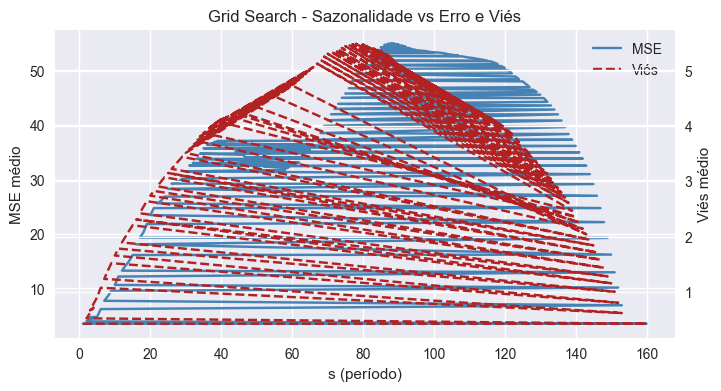

In [31]:
from tqdm.auto import tqdm

s_candidates = list(range(1, 161))

def grid_search_s(df, target_col, s_list):
    rows = []
    for s in tqdm(s_list, desc="Grid sazonalidade"):
        res = walk_forward(df, target_col, seasonal_naive, {"s": s})
        mse = np.mean((res["y_true"] - res["y_pred"]) ** 2)
        bias = (res["y_true"] - res["y_pred"]).mean()
        rows.append({"s": s, "MSE": mse, "Bias": bias})
    grid_df = pd.DataFrame(rows).sort_values("MSE")
    best_s = int(grid_df.iloc[0]["s"])
    return grid_df, best_s

grid_df, best_s = grid_search_s(df[["volume"]], "volume", s_candidates)
print(f"Melhor sazonalidade: s={best_s} | MSE={grid_df.iloc[0]['MSE']:.4f}")

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.plot(grid_df["s"], grid_df["MSE"], color="steelblue", label="MSE")
ax2.plot(grid_df["s"], grid_df["Bias"], color="firebrick", linestyle="--", label="Viés")
ax1.set_xlabel("s (período)")
ax1.set_ylabel("MSE médio")
ax2.set_ylabel("Viés médio")
ax1.set_title("Grid Search - Sazonalidade vs Erro e Viés")

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
ax1.legend(handles, labels, loc="upper right")
Path("imgs").mkdir(exist_ok=True)
fig.savefig("imgs/grid_search_seasonality.png", dpi=200, bbox_inches="tight")
plt.show()

## 5. Avaliação dos Baselines (Naive, Seasonal Naive, Mean, Drift)
Usa o `s` ótimo encontrado e calcula métricas agregadas nas predições walk-forward.

In [32]:
baseline_configs = {
    "Naive": (naive_last, {}),
    "Seasonal Naive": (seasonal_naive, {"s": best_s}),
    "Mean": (mean_history, {}),
    "Drift": (drift, {}),
}

res_by_model = {}
summary_rows = []
for name, (func, kwargs) in baseline_configs.items():
    res = walk_forward(df[["volume"]], "volume", func, kwargs)
    res_by_model[name] = res
    metrics = aggregate_metrics(res)
    summary_rows.append({"Modelo": name, **metrics})

summary_df = pd.DataFrame(summary_rows).set_index("Modelo")
summary_df[["R2", "MAE", "MSE", "RMSE", "Media dos Residuos"]]

,R2,MAE,MSE,RMSE,Media dos Residuos
Modelo,,,,,
Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Seasonal Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Mean,-0.603601,4.651042,37.671449,6.137707,4.648174
Drift,0.853469,1.327347,3.442281,1.855339,0.299659


## 6. Análise Gráfica dos Resíduos (h=1)
Função de autocorrelação (ACF) e distribuição dos resíduos para cada baseline.

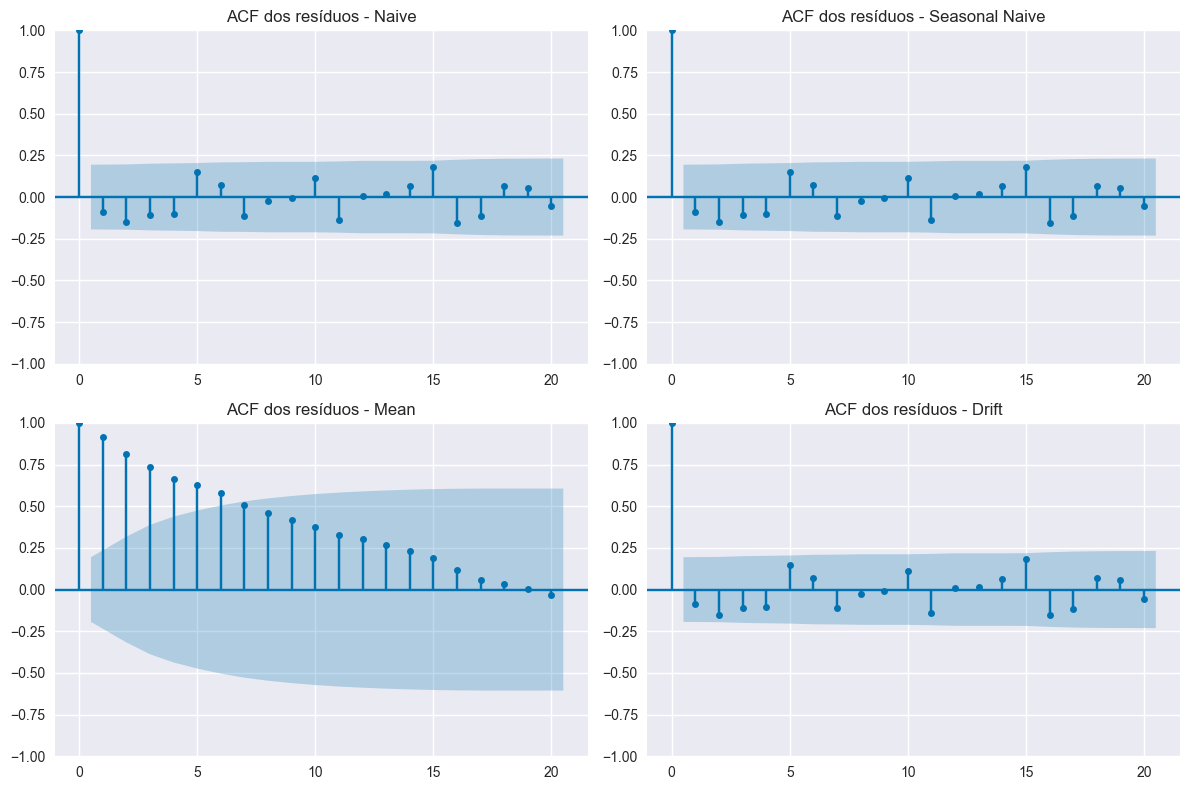

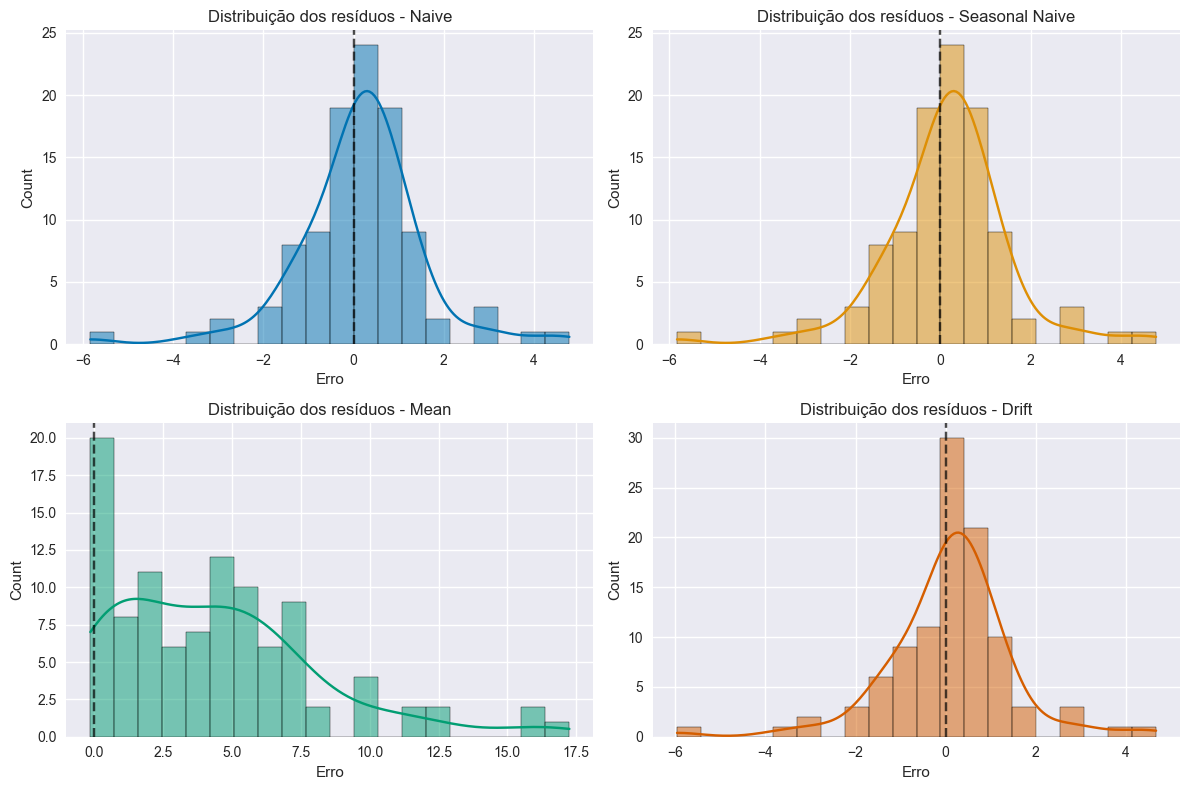

In [33]:
res_h1 = {name: res[res["horizon"] == 1].copy() for name, res in res_by_model.items()}
palette = sns.color_palette("colorblind", n_colors=len(res_h1))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, (name, res) in zip(axes, res_h1.items()):
    if len(res) > 1:
        plot_acf(res["residual"], ax=ax, lags=min(20, len(res) - 1))
    ax.set_title(f"ACF dos resíduos - {name}")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, (name, res), color in zip(axes, res_h1.items(), palette):
    sns.histplot(res["residual"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(0, color="black", linestyle="--", alpha=0.7)
    ax.set_title(f"Distribuição dos resíduos - {name}")
    ax.set_xlabel("Erro")
plt.tight_layout()
plt.show()

## 7. Síntese Quantitativa e Conclusão
Seleciona o melhor baseline (menor RMSE) e sumariza os achados em linha com o relatório.

In [34]:
best_model = summary_df["RMSE"].idxmin()
print(f"Melhor baseline pelo RMSE: {best_model}")
display(summary_df)

# Síntese textual curta
conclusions = []
conclusions.append(f"Seasonal Naive usa s={best_s} (grid search).")
conclusions.append(f"Melhor baseline: {best_model} (RMSE={summary_df.loc[best_model, 'RMSE']:.4f}).")
conclusions.append("Naive e Drift tendem a resíduos mais centrados em zero; Mean mostra viés maior se a série sobe/descai.")
conclusions.append("ACFs próximas de zero sugerem resíduos próximos de ruído branco para os melhores baselines.")
for c in conclusions:
    print("- ", c)

Melhor baseline pelo RMSE: Drift


,R2,MAE,MSE,RMSE,Media dos Residuos
Modelo,,,,,
Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Seasonal Naive,0.849886,1.330956,3.526443,1.877883,0.431838
Mean,-0.603601,4.651042,37.671449,6.137707,4.648174
Drift,0.853469,1.327347,3.442281,1.855339,0.299659


-  Seasonal Naive usa s=1 (grid search).
-  Melhor baseline: Drift (RMSE=1.8553).
-  Naive e Drift tendem a resíduos mais centrados em zero; Mean mostra viés maior se a série sobe/descai.
-  ACFs próximas de zero sugerem resíduos próximos de ruído branco para os melhores baselines.
